In [2]:
import os
import re
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly as px
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [3]:
direccion='../limpiezacolumnas/salida/'

In [4]:
dd=pd.DataFrame()
for path, subdirs, files in os.walk(direccion):
        for name in tqdm(files):
            if(len(name)<8):
                print(name)
            
                df=pd.read_csv(os.path.join(path, name))
                df["Hora"]=pd.to_datetime(df["Hora"],dayfirst=True)
                df = df.set_index('Hora')
                ix=df.index.values-3
                imputer = KNNImputer(n_neighbors=6)
                df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
                df['index']=ix
                dff = df.set_index('index')
                df=pd.melt(df, id_vars=['index'], var_name='NIS', value_name='KWh')
                df["cat"]=name[:3]
                
                dd = pd.concat([dd, df],axis=0)
                  #df["Hora"] 

 33%|███▎      | 2/6 [00:00<00:00, 14.49it/s]

141.csv
142.csv
245.csv
343.csv

100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


546.csv
846.csv


In [5]:

dd['hour'] = dd['index'].apply(lambda x: x.hour)

In [6]:
dd['day'] = dd['index'].apply(lambda x: x.dayofweek)

In [7]:
dd.head()

,index,NIS,KWh,cat,hour,day
0,2021-12-01 00:59:59.999999997,1572256,0.052,141,0,2
1,2021-12-01 01:59:59.999999997,1572256,0.046,141,1,2
2,2021-12-01 02:59:59.999999997,1572256,0.042,141,2,2
3,2021-12-01 03:59:59.999999997,1572256,0.044,141,3,2
4,2021-12-01 04:59:59.999999997,1572256,0.052,141,4,2


In [8]:
dd['max_KWh'] = dd.groupby(['cat'])['KWh'].transform(max)

In [9]:
dd['norm_KWh'] = dd['KWh']/ dd['max_KWh']

In [10]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import cluster 

In [11]:
red_df = dd[['cat','NIS',  'day', 'hour', 'norm_KWh']]
piv_df = pd.pivot_table(red_df, index = ['cat','NIS',  'day'], columns = 'hour', values = 'norm_KWh')
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby(['cat', 'NIS']).mean()
grp_df.reset_index(inplace = True)
del grp_df['day'] # This feature is not relevant any more

In [12]:
grp_df.head()

hour,cat,NIS,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,141,1007512,0.079627,0.080399,0.082430,0.084078,0.082393,0.066446,0.022521,0.006624,0.006295,0.004309,0.001408,0.002352,0.002920,0.002766,0.001729,0.001087,0.001035,0.002031,0.003488,0.015267,0.036850,0.048944,0.070533,0.077806
1,141,1009970,0.019867,0.019768,0.019688,0.019552,0.019181,0.019188,0.023812,0.016570,0.013405,0.010088,0.008050,0.008174,0.006130,0.006180,0.007032,0.006970,0.009258,0.007161,0.008711,0.011168,0.012397,0.012940,0.015619,0.018101
2,141,1010209,0.179288,0.182066,0.170052,0.175404,0.169762,0.202760,0.219046,0.209316,0.152397,0.157495,0.130714,0.172805,0.141820,0.116681,0.107377,0.097703,0.097640,0.130745,0.155303,0.186239,0.234708,0.208303,0.182609,0.190196
3,141,1013464,0.040042,0.039134,0.038208,0.040227,0.042987,0.041987,0.031813,0.025219,0.020587,0.021071,0.021361,0.023818,0.027047,0.032214,0.036912,0.042246,0.042855,0.042779,0.037706,0.035998,0.048049,0.054087,0.052124,0.045783
4,141,1015235,0.130424,0.119070,0.108841,0.103426,0.101568,0.148043,0.098710,0.094802,0.094384,0.090073,0.096296,0.099031,0.123762,0.124534,0.109205,0.103673,0.100416,0.102620,0.110203,0.166218,0.198086,0.198753,0.173139,0.139820


In [145]:
kmeans_df = grp_df#pd.get_dummies(grp_df, columns =['cat','NIS'])

In [146]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

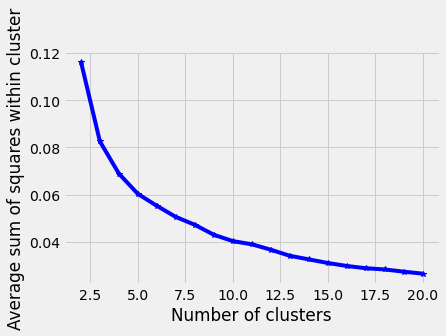

In [147]:
k_algs, k_res = elbow_method(kmeans_df.drop(['cat', 'NIS'], axis = 1), 2, 20)

In [148]:
algorithm = k_algs[4] # Values of k are {2, 3, 4, 5, ..., 20} so k = 6 corresponds to the element with index 4
clustering = k_res[4]

In [149]:
clustering.cluster_centers_

array([[0.02358814, 0.02242694, 0.02197369, 0.02176704, 0.02268489,
        0.02314334, 0.02288192, 0.0235788 , 0.02498862, 0.02539271,
        0.0259757 , 0.02630156, 0.02578107, 0.0261788 , 0.02718314,
        0.02758908, 0.02649418, 0.02530145, 0.02370035, 0.02398055,
        0.02583024, 0.02672065, 0.02553957, 0.02462717],
       [0.24050831, 0.23314594, 0.22478247, 0.21467766, 0.22423645,
        0.24393671, 0.26033739, 0.28981122, 0.30021202, 0.30369887,
        0.31210392, 0.31591108, 0.31507653, 0.34054884, 0.35418209,
        0.35665096, 0.34949289, 0.33273668, 0.31527691, 0.29796719,
        0.27710853, 0.26635718, 0.25541291, 0.24910977],
       [0.24382191, 0.25576953, 0.25920578, 0.25558798, 0.25545498,
        0.25075479, 0.24101828, 0.22850428, 0.22058614, 0.21164812,
        0.19672209, 0.18550082, 0.17218999, 0.16592035, 0.15832321,
        0.15657585, 0.15720629, 0.15863172, 0.16713772, 0.17532807,
        0.19445661, 0.20113641, 0.20986139, 0.22785294],
       [0.504

In [150]:
cls_list = algorithm.predict(kmeans_df.drop(['cat', 'NIS'], axis = 1))

In [151]:
kmeans_df['cluster'] = cls_list

In [152]:
def print_building_types_in_clusters(data):
    for tp in data['cat'].unique():
        print('How many cat of type', tp, 'are in each cluster?')
        print(data[data.cat == tp]['cluster'].value_counts())

In [153]:
print_building_types_in_clusters(kmeans_df)

How many cat of type 141 are in each cluster?
5    18
0    17
4     7
2     3
Name: cluster, dtype: int64
How many cat of type 142 are in each cluster?
0    38
5    31
4    24
2    15
1     3
Name: cluster, dtype: int64
How many cat of type 245 are in each cluster?
0    54
5    22
4    12
1    10
2     7
3     2
Name: cluster, dtype: int64
How many cat of type 343 are in each cluster?
0    26
5    16
4    13
1     6
2     4
3     2
Name: cluster, dtype: int64
How many cat of type 546 are in each cluster?
0    43
5    22
4    11
2     6
1     6
3     1
Name: cluster, dtype: int64
How many cat of type 846 are in each cluster?
0    24
5    12
4     2
1     2
3     2
2     1
Name: cluster, dtype: int64


In [154]:
def make_cluster_table(data):
    tbl = data[['cat', 'cluster']]
    tbl_grp = tbl.groupby(tbl.columns.tolist(), as_index = False).size()
    tbl_frm = tbl_grp#.reset_index().drop('index')
    
    tbl_frm.columns = ['cat', 'cluster','count']
    tbl_pvt = pd.pivot_table(tbl_frm, index = 'cat', columns = 'cluster', values = 'count').fillna(0).astype(int)
    return (tbl_frm, tbl_pvt)

In [155]:
tbl_frm, tbl_pvt = make_cluster_table(kmeans_df)
tbl_pvt

cluster,0,1,2,3,4,5
cat,,,,,,
141,17,0,3,0,7,18
142,38,3,15,0,24,31
245,54,10,7,2,12,22
343,26,6,4,2,13,16
546,43,6,6,1,11,22
846,24,2,1,2,2,12


In [156]:


from matplotlib.ticker import MaxNLocator

def cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['count'])
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq)
    plt.show()



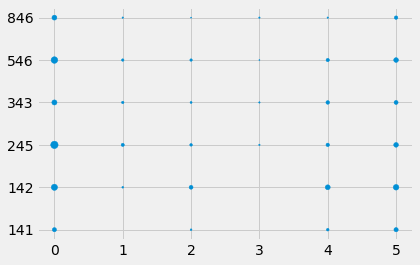

In [157]:
cluster_scatter_plot(tbl_frm)

In [158]:
 tbl_frm.head()

,cat,cluster,count
0,141,0,17
1,141,2,3
2,141,4,7
3,141,5,18
4,142,0,38


In [159]:
def compute_building_share(original_df, kmeans_df, tbl_frm):
    bld_share = {}
    for tp in original_df['cat'].unique():
        tot_num_buildings = len(original_df[original_df.cat == tp].groupby('NIS'))
        bld_share[tp] = {}
        for c in kmeans_df['cluster'].unique():
            nb = tbl_frm[(tbl_frm.cat == tp) & (tbl_frm.cluster == c)]['count']
            if not nb.empty:
                bld_share[tp][c] = int(nb) / tot_num_buildings
    return bld_share

In [160]:
bld_share = compute_building_share(dd, kmeans_df, tbl_frm)
tbl_frm['bld_pct'] = tbl_frm.apply(lambda row: bld_share[row['cat']][row['cluster']], axis = 1)

In [161]:
def norm_cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['bld_pct'].apply(lambda x: x * 100))
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq);

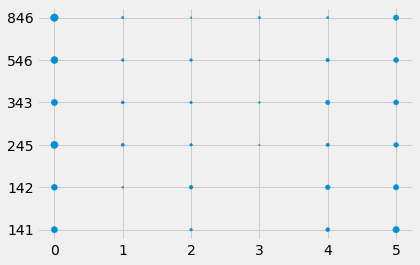

In [162]:
norm_cluster_scatter_plot(tbl_frm)

In [163]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'KWh', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

In [164]:
def clusters_visualisation(kmeans_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_KWh')
    clusters = kmeans_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0,ymax=0.5, ycol = 'norm_KWh', opacity = 0.1, title = 'Cluster ' + str(c))

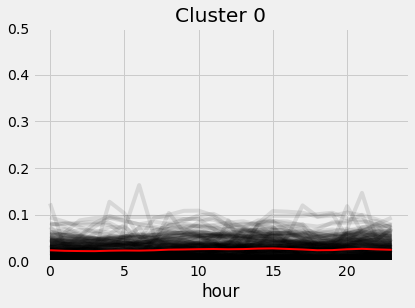

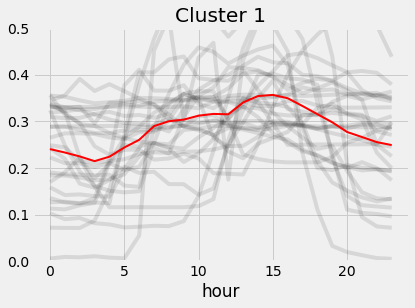

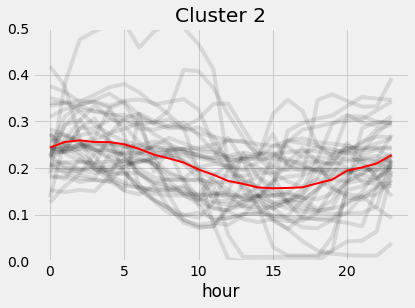

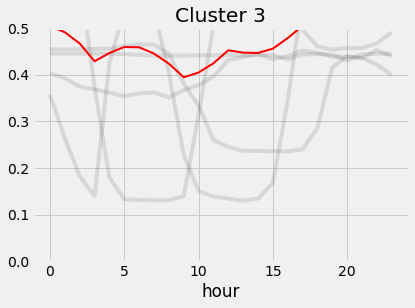

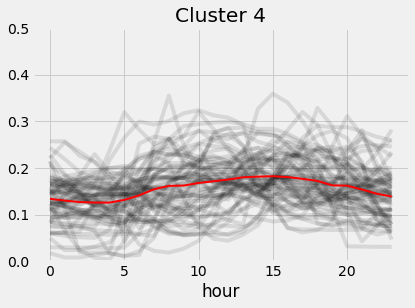

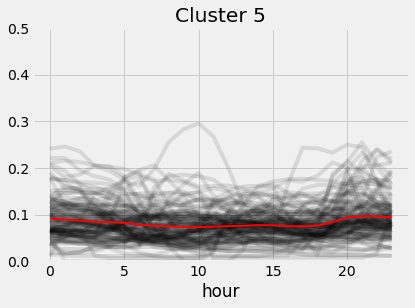

In [165]:
clusters_visualisation(kmeans_df, id_vars = ['cat', 'NIS', 'cluster'], value_vars = list(kmeans_df.columns))